In [1]:
import numpy as np
import pydub
import matplotlib.pyplot as plt
import sys

In [2]:
path = "./songs/epic_part.mp3"
sound = pydub.AudioSegment.from_file(path, format="mp3", frame_rate=44100, channels=1, sample_width=1)

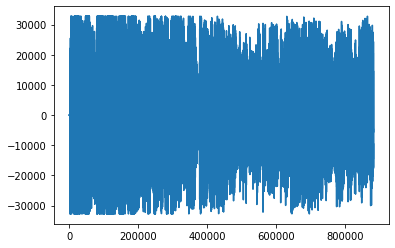

882000


In [3]:
plot_1sec = sound[:10000].get_array_of_samples()
plt.plot(plot_1sec)
plt.show()
print(len(sound[:10000].get_array_of_samples()))

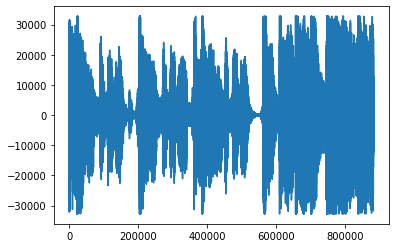

882000


In [4]:
original = pydub.AudioSegment.from_file("./songs/This_Is_It.mp3", format="mp3", frame_rate=44100, channels=1, sample_width=1)
plot_1sec = original[74000:84000].get_array_of_samples()
plt.plot(plot_1sec)
plt.show()
print(len(original[:10000].get_array_of_samples()))

In [5]:
song = np.array(original.get_array_of_samples())
part = np.array(sound.get_array_of_samples())

In [6]:
def sample(song):
    size = len(song)
    chunk_size = 4000
    sampled_chunk_size = int(size/chunk_size)

    sampled = np.zeros(shape=(sampled_chunk_size, chunk_size), dtype=np.complex_)

    for i in range(sampled_chunk_size):
        time_variations = np.zeros(chunk_size, dtype=np.complex_)

        for j in range(chunk_size):
            time_variations[j] = complex(song[i * chunk_size + j], 0)

    #     print(time_variations)
        sampled[i] = np.fft.fft(time_variations)
    #     print(sampled[i])
    # plt.plot(sampled)
    # plt.show()
    
    return sampled

In [7]:
# for i in sampled[:100]:
#     for j in i:
#         if j.real != 0:
#             print(abs(j.real))

In [8]:
FREQUENCIES = [40, 80, 120, 180, 300]

def get_range_of_frequency(frq):
    return max(list(range(len(FREQUENCIES))), key = lambda x: FREQUENCIES[x] > frq)

In [9]:
def get_fuzzed(peak, fuzz):
    return np.int64(peak - (peak%fuzz))

In [10]:
def fingerprint_hash(peaks):
    fuzz_factor = 2
    i = 1
    fingerprint = np.int64(0)
    
    for p in peaks:
        fingerprint+=get_fuzzed(p, fuzz_factor) * i
        i*=1000
#     print("fingerprint", fingerprint.astype(np.int64))
    return fingerprint

In [11]:
def point_position(number, pos=2): #pos=2 -> 3 digit number
    while(number < 10**pos):
        number*=10
    num = number.astype(np.int64)
#     print("number: ", num)
    return num

In [12]:
def fingerprint(sampled):
    peaks = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)), dtype=np.int64)
    values = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)), dtype=np.int64)

    highest = np.zeros(shape=(sampled.shape[0], len(FREQUENCIES)), dtype=np.float64)
    
    hashed = np.zeros(shape=sampled.shape[0], dtype=np.int64)
    unique = []
    
    for i in range(0, sampled.shape[0]):
        for frq in range(40, 300):
            magnitude = np.log(np.abs(sampled[i][frq])+1)
    #         if magnitude != 0:
    #             print(np.log2(np.abs(sampled[i][frq])+1))
            range_index = get_range_of_frequency(frq)
    #         print("magnitude: ", magnitude)
    #         print("highest: ", highest[i][range_index])

    #         print(highest[i][range_index])
    #         if magnitude > highest[i][range_index]:
    #             highest[i][range_index] = frq
    #             values[i][range_index] = magnitude
    #             peaks[i][range_index] = point_position(magnitude)

            if magnitude > highest[i][range_index]:
                highest[i][range_index] = magnitude
                values[i][range_index] = frq
                peaks[i][range_index] = frq

        hashed[i] = fingerprint_hash(peaks[i])
        unique.append(tuple(values[i]))
    
    return hashed, unique

In [13]:
sampled = sample(part)
sampled_full = sample(song)

hashed, unique = fingerprint(sampled)
hashed_full, unique_full = fingerprint(sampled_full)

unique full: 3679 unique:  221


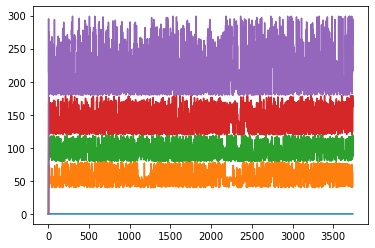

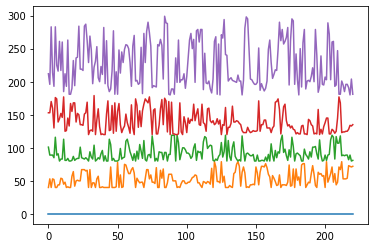

268126094066000
248126086040000
196124082046000
222178104046000
230120080040000
252142082052000
206158084056000
200132082040000
222120090040000
210120096040000
282120080040000
196120088040000
262150080040000
194170080040000
184126112040000
188126104070000
216164080040000
276122084040000
180168080040000
214124080040000


In [14]:
hashed = np.trim_zeros(hashed)
hashed_full = np.trim_zeros(hashed_full)

# plt.hist(hashed)
print("unique full:", len(list(set(unique_full))), "unique: ", len(list(set(unique))))
plt.plot(unique_full)
plt.show()

plt.plot(unique)
plt.show()
# print(unique)
# print("hashed:", len(hashed[:100]))
for i in hashed[30:50]:
    print(i)

In [15]:
for i in hashed_full[30:50]:
    print(i)

194128102056000
190144104046000
200162118046000
230124112048000
216126088050000
200126100050000
200124100050000
200124100050000
182142104052000
224124100048000
268124088050000
184124088068000
188122080040000
182128106040000
180146104042000
234122102040000
188162086056000
202152084042000
254130094042000
180128092046000


In [16]:
matching = 0
for i, e in enumerate(hashed_full):
    if i > len(hashed):
        break
    if e in hashed[i:]:
        matching+=1
print(matching)

0


In [17]:
current_index = 0
count = 0
epsilon = 1158090044000
max_diff = epsilon * 2
prev = hashed[1]
size = len(hashed)

for i in range(size):
    difference = np.abs(hashed[i]-hashed_full[current_index])
    prev_difference = np.abs(hashed[i]-hashed_full[current_index-1])
    if difference < epsilon:
        current_index+=1
        count+=1
    if difference > max_diff:
        if prev_difference < epsilon:
            current_index-=2
            count+=1
        current_index+=1
        prev = hashed[i]
        
    if np.abs(prev-hashed[current_index]) < epsilon:
        count+=1
        
print(count)
print(matching + count)

47
47


In [18]:
epsilon = 1158090044000
count = 0
full_index = 0
i = 2
while i < len(hashed):    
    prev_h = hashed[i-2]
    current_h = hashed[i-1]
    next_h = hashed[i]
#     print("current:", current_h, "index: ", i, ":", full_index)
    if np.abs(prev_h - hashed_full[full_index]) <= epsilon:
        matched = full_index
        full_index+=1
        count+=1
#         print(prev_h, " - ", hashed_full[full_index-1])
    elif full_index > i and full_index-(i-2) > 2:
        i = full_index
    else:
        if np.abs(next_h - hashed_full[full_index]) <= epsilon:
            if np.abs(prev_h - hashed_full[full_index+1]) <= epsilon:
                full_index+=1
                i-=1
            elif np.abs(current_h - hashed_full[full_index+1]) <= epsilon:
                full_index+=1
            else:
                i+=1
        elif np.abs(current_h - hashed_full[full_index]) <= epsilon:
            i+=1
            continue
        else:
            full_index+=1
            i-=1
    i+=1
print(count)

13


In [19]:
epsilon = 1158090044000
count = 0
i = 2

for j in range(len(hashed_full)):
    if len(hashed_full) - j < len(hashed):
        break
    maximum = 0
    full_index = j
    while i < len(hashed):    
        prev_h = hashed[i-2]
        current_h = hashed[i-1]
        next_h = hashed[i]
    #     print("current:", current_h, "index: ", i, ":", full_index)
        if np.abs(prev_h - hashed_full[full_index]) <= epsilon:
            matched = full_index
            full_index+=1
            maximum+=1
    #         print(prev_h, " - ", hashed_full[full_index-1])
        elif full_index > i and full_index-(i-2) > 2:
            i = full_index
        else:
            if np.abs(next_h - hashed_full[full_index]) <= epsilon:
                if np.abs(prev_h - hashed_full[full_index+1]) <= epsilon:
                    full_index+=1
                    i-=1
                elif np.abs(current_h - hashed_full[full_index+1]) <= epsilon:
                    full_index+=1
                else:
                    i+=1
            elif np.abs(current_h - hashed_full[full_index]) <= epsilon:
                i+=1
                continue
            else:
                full_index+=1
                i-=1
        i+=1
#     print(maximum)
    if maximum > count:
        count = maximum
print(count)

13


In [20]:
count = 0
epsilon = 2132080040000
for i in range(len(hashed_full)):
    if len(hashed)+i > len(hashed_full):
        break
    max_ = 0
    for j in range(len(hashed)):
        if np.abs(hashed[j]-hashed_full[i+j]) <= epsilon:
            max_+=1
    if max_ > count:
        count = max_
print(count)

28


In [21]:
valid = (count+matching)*100/len(hashed)
print(valid)
if valid > 45:
    print("matched")
else:
    print("not matching")

12.669683257918551
not matching
